1. load the best model and give the last BatchNormalization layer index as output
2. define datapath (only a couple of contigs will be used)
3. in args: set features and stats file

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
np.random.seed(5)
import pandas as pd
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import tensorflow as tf

2022-02-06 14:38:57.849593: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import sys
sys.path.insert(1, '/cluster/home/omineeva/ResMiCo')
from resmico import contig_reader
from resmico import utils
from resmico import models_fl as Models
from resmico.commands.evaluate import parse_args
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import seaborn as sns
colors = ['#4daf4a', '#e41a1c',  '#377eb8', '#984ea3', '#ff7f00', '#ffff33']
sns.set(font_scale=1.2, style="whitegrid", palette=sns.color_palette(colors))

In [5]:
project_path = '/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/'

data_path = project_path + \
            'data/v2/resmico-sm/GTDBr202_n9k_novel-family_test/features/' + \
            '0.111111/mean-10-sigma-1/1/100/2000000/metaspades/'

stats_file = project_path + \
            '/data/v2/resmico-sm/GTDBr202_n9k_train/' + \
            'stats.json'

# model_name = project_path + 'Outputs/mc_epoch_40_aucPR_0.605_mask-111-gpu2-d02-fl16-nblo4_model.h5'
# model_name = '/cluster/home/ddanciu/tmp/mc_epoch_30_aucPR_0.660_resmico_model.h5'
# model_name = '/cluster/home/ddanciu/tmp/mc_epoch_28_aucPR_0.657_resmico_model.h5'
# model_name = '/cluster/home/ddanciu/tmp/mc_epoch_46_aucPR_0.647_resmico_model.h5' 
# model_name = project_path +'/Outputs/mc_epoch_44_aucPR_0.685_upcov-111-d02-fl16-nblo4_model.h5'
model_name = project_path + '/Outputs/mc_epoch_40_aucPR_0.727_resmico_10000_2022-01-20_09-30-25_model.h5'

In [6]:
custom_obj = {'class_recall_0': utils.class_recall_0, 'class_recall_1': utils.class_recall_1,
              'GlobalMaskedMaxPooling1D': Models.GlobalMaskedMaxPooling1D}


model = load_model(model_name, custom_objects=custom_obj)

2022-02-06 14:39:02.468603: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-06 14:39:02.470810: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-06 14:39:02.485712: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-06 14:39:02.485752: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: le-g3-007
2022-02-06 14:39:02.485761: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: le-g3-007
2022-02-06 14:39:02.485949: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.80.2
2022-02-06 14:39:02.486000: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.80.2
2022-02-06 14:39:02.486007: I tensorflow/stream_executor/cu

In [7]:
model.layers

In [8]:
middle_output = Model(inputs=model.input, outputs=model.layers[-6].output)

In [9]:
mask_output = Model(inputs=model.input, outputs=model.layers[-5].output)

In [10]:
# weights = model.layers[-1].get_weights()
# were used when only one dense layer

In [11]:
joint_line = ''

joint_line += ' --features'
features_set17=" ref_base num_query_A num_query_C num_query_G num_query_T num_SNPs num_proper_Match num_orphans_Match mean_al_score_Match coverage stdev_insert_size_Match max_insert_size_Match mean_mapq_Match min_mapq_Match"
features_D = " ref_base num_query_A num_query_C num_query_G num_query_T num_SNPs num_proper_Match num_orphans_Match mean_al_score_Match coverage stdev_insert_size_Match mean_mapq_Match"
features_upcov=" mean_al_score_Match mean_mapq_Match num_orphans_Match mean_insert_size_Match min_al_score_Match num_proper_Match min_insert_size_Match num_proper_SNP coverage"
joint_line += features_D

joint_line += ' --feature-files-path '
joint_line += data_path

joint_line += ' --stats-file '
joint_line += stats_file

joint_line += ' --mask-padding'
joint_line += ' --binary-data '

In [12]:
args = parse_args().parse_args(joint_line.split())

In [13]:
args

Namespace(model='/cluster/home/omineeva/ResMiCo/resmico/model/fl_all_model.h5', batch_size=100, sdepth=None, rich=None, filter10=False, rep10=False, method_pred='chunks', min_len=1000, mem_lim=500000, window=5000, v1=False, longdir=False, embeddings=False, emb_ind=0, binary_data=True, gpu_eval_mem_gb=3.0, val_ind_f=None, chunks=False, log_level='INFO', no_cython=False, seed=12, n_procs=1, max_len=10000, save_path='.', save_name='resmico', feature_files_path='/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/data/v2/resmico-sm/GTDBr202_n9k_novel-family_test/features/0.111111/mean-10-sigma-1/1/100/2000000/metaspades/', feature_file_table='', technology='all-asmbl', big_data=False, features=['ref_base', 'num_query_A', 'num_query_C', 'num_query_G', 'num_query_T', 'num_SNPs', 'num_proper_Match', 'num_orphans_Match', 'mean_al_score_Match', 'coverage', 'stdev_insert_size_Match', 'mean_mapq_Match'], stats_file='/cluster/home/omineeva/global_projects/projects/projects2

In [14]:
if args.mask_padding:
    convoluted_size = Models.construct_convolution_lambda(model)
else:  # when not padding, the convoluted size is unused
    convoluted_size = lambda len, pad: 0

In [15]:
reader = contig_reader.ContigReader(args.feature_files_path, args.features, args.n_procs, args.chunks,
                                    args.no_cython, args.stats_file, args.min_len)

In [16]:
# eval_idx = []
# for ind, contig in enumerate(reader.contigs):
#     if contig.length > 7000 and contig.length < 9000 and contig.misassembly == 1: 
# #     if contig.length > 1700 and contig.misassembly == 1: 
# #     if contig.name == 'NODE_1576_length_1934_cov_1.551357':
# #     if ind in set([163, 5461, 5500, 5510]):
# # #         print (ind)
# #         print(contig.name)
# #  'NODE_2209_length_1631_cov_1.418147', wrong prediction +, averageD +
# #  'NODE_1219_length_2221_cov_2.613573', wrong -, averageD +
# #  'NODE_2868_length_1433_cov_2.236575', correct +, averageD +
# #  'NODE_4888_length_1087_cov_1.323643'  wrong -
#         eval_idx.append(ind)   

In [33]:
# select based on the story we want to tell here

# eval_idx = [5616, 778, 3615, 740 ] # plot1 5422 5569
eval_idx = [311, 1174, 163, 1521] # plot2
 
#plot2 [163, 311, 851, 1174] #5663  163, 5461, 5500, 5510

In [34]:
predict_data = Models.BinaryDatasetEval(reader, eval_idx, args.features, args.max_len, max(250, args.max_len-500),
                                        int(args.gpu_eval_mem_gb * 1e9 * 0.8), cache_results=False,
                                        show_progress=False, convoluted_size=convoluted_size, pad_to_max_len=False)

In [35]:
preds = predict_data.__getitem__(0)

In [36]:
# sum(preds[0][1][2]), len(preds[0][1][2])

In [37]:
# convert the slow Keras predict_data of type Sequence to a tf.data object
data_iter = lambda: (s for s in predict_data)

predict_data_tf = tf.data.Dataset.from_generator(
    data_iter,
    output_signature=(
        # first dimension is batch size, second is contig length, third is number of features
        (tf.TensorSpec(shape=(None, None, len(predict_data.expanded_feature_names)), dtype=tf.float32),
         # first dimension is batch size, second is contig length (no third dimension,
         # as all features are masked the same way)
         tf.TensorSpec(shape=(None, None), dtype=tf.bool)),
        tf.TensorSpec(shape=(None), dtype=tf.bool)
    ))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
predict_data_tf = predict_data_tf.with_options(options)  # avoids Tensorflow ugly console barf

In [38]:
eval_data_flat_y = model.predict(x=predict_data_tf,
                                 workers=args.n_procs,
                                 use_multiprocessing=False,
                                 max_queue_size=max(args.n_procs, 10),
                                 verbose=1)
eval_data_predicted_min = predict_data.group(eval_data_flat_y, min)
eval_data_predicted_mean = predict_data.group(eval_data_flat_y, np.mean)
eval_data_predicted_std = predict_data.group(eval_data_flat_y, np.std)
# eval_data_predicted_max = round(predict_data.group(eval_data_flat_y, max)[0], 3)
eval_data_predicted_max = predict_data.group(eval_data_flat_y, max) #use this if >1 contig
eval_data_predicted_max

1/1 [==============================] - 0s 92ms/step


array([4.97661058e-05, 1.97669506e-01, 4.40099299e-01, 8.29031110e-01])

In [39]:
print(np.argmax(eval_data_predicted_max), eval_idx[2])

3 163


In [40]:
eval_data_flat_y = middle_output.predict(x=predict_data_tf,
                                 workers=args.n_procs,
                                 use_multiprocessing=False,
                                 max_queue_size=max(args.n_procs, 10),
                                 verbose=1)

1/1 [==============================] - 0s 93ms/step


In [41]:
# mask_y = mask_output.predict(x=predict_data_tf,
#                                  workers=args.n_procs,
#                                  use_multiprocessing=False,
#                                  max_queue_size=max(args.n_procs, 10),
#                                  verbose=1)
# len(mask_y[0])-sum(mask_y[0])

In [42]:
down = 8
for i in range(4):
    for breakpoint in reader.contigs[eval_idx[i]].breakpoints:
        print(breakpoint[0]/down)
    print('length: ', reader.contigs[eval_idx[i]].length//down)

length:  205
length:  241
length:  378
length:  325


In [43]:
ind=2
max_len = len(preds[0][1][ind])
#45 positions are lost because of the valid padding

In [44]:
savefig_path=project_path+'Outputs/figures'

#examples to show in main part: two misassembly correctly classified, 
                                two wrongly classified misassembly: correct spike, wrong spike position
                                
                                
#suppliment: two correctly classified good contigs: without spikes, with spike
             two false positives

In [45]:
def posargmax(ind):
    max_len = len(preds[0][1][ind])
    cont_len = sum(preds[0][1][ind])
    mask = max_len - cont_len
    print(mask)
    pos_kernel = np.zeros(cont_len)
    for i, kernel in enumerate(eval_data_flat_y[ind].T):
#         print(kernel)
        if mask>0:
            pos_kernel[np.argmax(kernel[:-mask])]+=max(kernel[:-mask])  
        else: 
            pos_kernel[np.argmax(kernel)]+=max(kernel) 

    return pos_kernel

def sumkernels(ind):
    max_len = len(preds[0][1][ind])
    cont_len = sum(preds[0][1][ind])
    mask = max_len - cont_len
    pos_kernel = np.zeros(cont_len)
    for i, kernel in enumerate(eval_data_flat_y[ind].T):
        if mask>0:
            pos_kernel+=kernel[:-mask]
        else: 
            pos_kernel+=kernel 

    return pos_kernel/(i+1)

def bp(ind):
    return reader.contigs[eval_idx[ind]].breakpoints[0][0]//8 - 45/2 
#45 is number of pos cutted because of val padding

def text_cont(ind):
    return 'label: ' + str(reader.contigs[eval_idx[ind]].misassembly) + \
            '\n'+ 'resmico score: ' + str(round(eval_data_predicted_max[ind], 3)) 

In [46]:
where = os.path.join(savefig_path, 
                    'bp:'+'_'.join(str(elem) for elem in eval_idx)+
                     '.pdf')

/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/Outputs/figures/with_bp:5616_778_3615_740.pdf


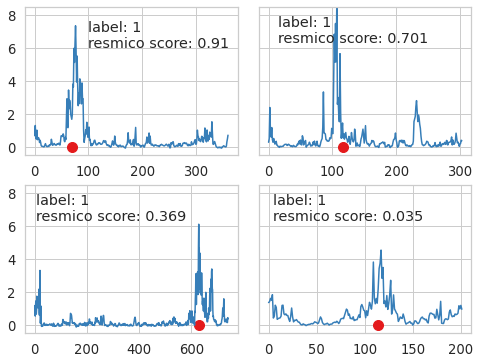

In [31]:
#
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8, 6))
fig.subplots_adjust(wspace=0.1, hspace=0.2)
ind = 0
axs[0][0].plot(sumkernels(ind), c=colors[2])
axs[0][0].scatter(bp(ind), 0, s=100, c=colors[1], marker='o')
axs[0][0].text(100, 6, text_cont(ind))
axs[0][0].set_ylim(-0.5, 8.5)

ind = 1
axs[0][1].plot(sumkernels(ind), c=colors[2])
axs[0][1].scatter(bp(ind), 0, s=100, c=colors[1], marker='o')
axs[0][1].text(15, 6.3, text_cont(ind))

ind = 2
axs[1][0].plot(sumkernels(ind), c=colors[2])
axs[1][0].scatter(bp(ind), 0, s=100, c=colors[1], marker='o')
axs[1][0].text(5, 6.3, text_cont(ind))

ind = 3
axs[1][1].plot(sumkernels(ind), c=colors[2])
axs[1][1].scatter(bp(ind), 0, s=100, c=colors[1], marker='o')
axs[1][1].text(5, 6.3, text_cont(ind))

where = os.path.join(savefig_path, 
                    'with_bp:'+'_'.join(str(elem) for elem in eval_idx)+
                     '.pdf')
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)
print(where)

plt.show()

/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/Outputs/figures/without_bp:311_1174_163_1521.pdf


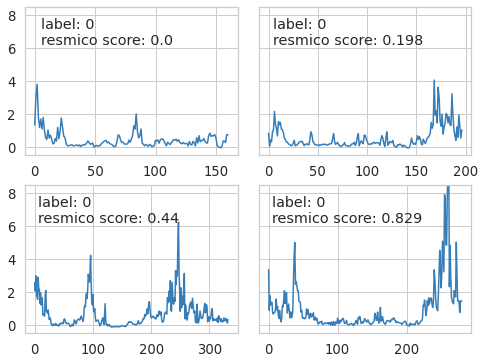

In [47]:
#
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8, 6))
fig.subplots_adjust(wspace=0.1, hspace=0.2)
ind = 0
axs[0][0].plot(sumkernels(ind), c=colors[2])
axs[0][0].text(5, 6.2, text_cont(ind))
axs[0][0].set_ylim(-0.5, 8.5)

ind = 1
axs[0][1].plot(sumkernels(ind), c=colors[2])
axs[0][1].text(5, 6.2, text_cont(ind))

ind = 2
axs[1][0].plot(sumkernels(ind), c=colors[2])
axs[1][0].text(5, 6.2, text_cont(ind))

ind = 3
axs[1][1].plot(sumkernels(ind), c=colors[2])
axs[1][1].text(5, 6.2, text_cont(ind))

where = os.path.join(savefig_path, 
                    'without_bp:'+'_'.join(str(elem) for elem in eval_idx)+
                     '.pdf')
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)
print(where)

plt.show()